# Implementation and Expermientation on the DE algorithm


## Setting up the test problem

To begin with we'll need to implement the necesarry modules to be used in this implementation of the differential evolution algorithm.

In [2]:
import numpy as np

Next we'll define and set the parameters for a test problem. In the case of this implementation I have decided to use the Vehicle Routing problem (VRP).

In [11]:
# Define problem parameters
NUM_CUSTOMERS = 5
NUM_VEHICLES = 3
CAPACITY = 20
DE_POPULATION_SIZE = 50
DE_MAX_GENERATIONS = 50
DE_CR = 0.8
DE_F = 0.5

An important aspect of the VRP, is the customer demands. This parameter dictates what each cutomer needs and decides whether a vehicle traveling on that route can meet those needs. 

This parameter is set randomly at the start of the problem. To begin with for continuity purposes the seed of the random number generator is given a set value, however, later when testing this seed will not be set.

In [37]:
# Generate random customer demands
np.random.seed(42)
customer_demands = np.random.randint(1, 3, size=NUM_CUSTOMERS)
print('Customer Demands: ', customer_demands)

Customer Demands:  [1 2 1 1 1]


The next step when setting up the VRP is to generate an array of locations and distances between those locations.
<br>The number of locations is equal to the number of customers +1 to include the depot where the vehicles start.
<br><font color='red'>Note: The vehicle depot has a cutomer demand of 0</font>
<br>This is represented as index 0 in the locations array.
<br>The locations are implemented as and array of 2 dimensional coordinates with values between 0 and 1.
<br>The distances are stored as $n \times n$ array where the values are calculated as the euclidean distance between all locations and $n$ is the number of customers +1.

In [38]:
# Define distance matrix
locations = np.random.rand(NUM_CUSTOMERS + 1, 2)
distances = np.zeros((NUM_CUSTOMERS + 1, NUM_CUSTOMERS + 1))
for i in range(NUM_CUSTOMERS + 1):
    for j in range(i + 1, NUM_CUSTOMERS + 1):
        distances[i, j] = np.linalg.norm(locations[i] - locations[j])
        distances[j, i] = distances[i, j]

We can display these locations and distances visually using the matplotlib and networkx modules.
<br> The value in brackets on each node correlates to the customer demand of that location produced earlier.
<br><font color='red'>Note: In this network graph we have rounded the edge weights to 2 decimal places to make it more readable.</font>

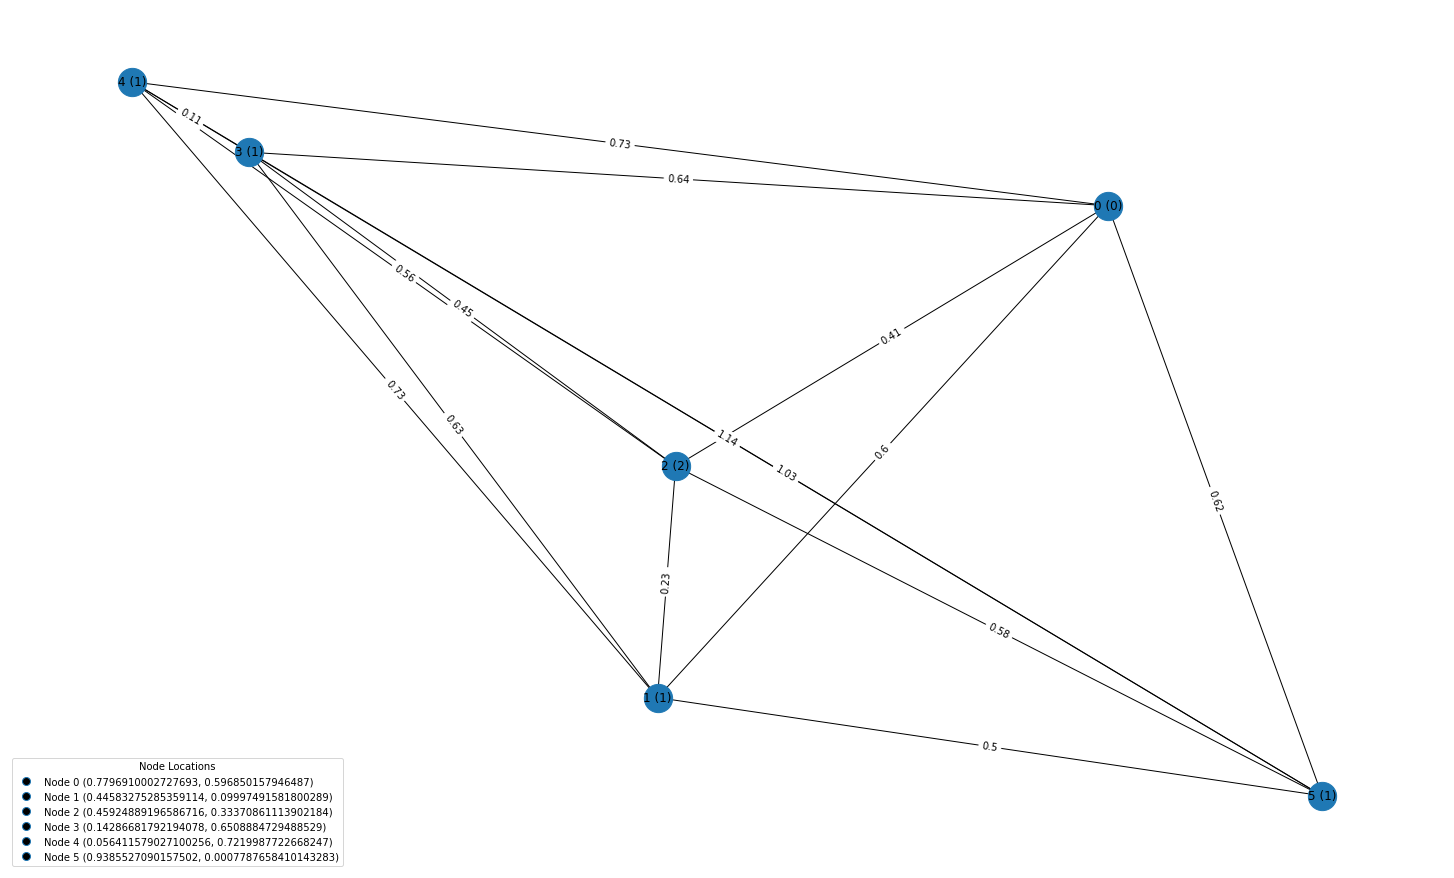

In [51]:
import networkx as nx
import matplotlib.pyplot as plt

# Define plot size
width = 20
height = 12

# Create graph with locations as nodes
G = nx.Graph()
for i in range(NUM_CUSTOMERS + 1):
    demand = customer_demands[i-1] if i > 0 else 0
    G.add_node(i, pos=locations[i], demand=demand)

# Add edges between nodes with non-zero distances
for i in range(NUM_CUSTOMERS + 1):
    for j in range(i + 1, NUM_CUSTOMERS + 1):
        if distances[i, j] > 0:
            G.add_edge(i, j, weight=round(distances[i, j], 2))

# Draw graph with node positions and edge weights
#pos = nx.get_node_attributes(G, 'pos')
#edge_labels = nx.get_edge_attributes(G, 'weight')
#plt.figure(figsize=(width, height))
#nx.draw(G, pos, with_labels=True)
#nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
# Draw graph with node positions, demand, and edge weights
pos = nx.get_node_attributes(G, 'pos')
demands = nx.get_node_attributes(G, 'demand')
labels = {i: f'{i} ({demands[i]})' for i in G.nodes}
edge_labels = nx.get_edge_attributes(G, 'weight')
plt.figure(figsize=(width, height))
nx.draw(G, pos, with_labels=False, node_size=800)
nx.draw_networkx_labels(G, pos, labels=labels, font_size=12, font_family='sans-serif')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

# Add legend with node IDs and coordinates
legend_handles = [plt.Line2D([0], [0], linestyle='', marker='o', markersize=8, markerfacecolor='black', label=f'Node {i} ({x}, {y})') for i, (x, y) in pos.items()]
plt.legend(handles=legend_handles, loc='lower left', title='Node Locations')
plt.show()

The final step when defining the test problem is to build a fitness fuction for the problem.
<br>The first step to doing this is to consider what a solution to the VRP will look like.
<br> In my implementation I decided to store a solution as 1 dimmensional array, where the value '0' dictates the start and end of a vehicles route.
<br> Our fitness function then needs to take in this array, split it up into its seperate routes and calculate the distance of each route.
<br> Finally we sum the distance of all the routes to get the total distance travelled by the vehicles and use that as the fitness value.

In [53]:
# Define fitness function
def fitness(solution):
    """
    Computes the total distance traveled by all vehicles in the solution, given a list of routes.
    """
    routes = np.split(solution, np.where(solution == 0)[0])
    routes = [r for r in routes if len(r) > 0]
    total_distance = 0
    for r in routes:
        route_distance = 0
        for i in range(len(r) - 1):
            route_distance += distances[r[i], r[i + 1]]
        total_distance += route_distance
    return total_distance

We can test the fitness function by giving it a dummy solution.
<br>Using the test problem above we can create a solution such as [0, 5, 1, 0, 2, 0, 4, 3, 0].
<br>This indicates that vehicle 1 visits locations 5 and 1, vehicle 2 visits location 2 and vehicle 3 visits locations 4 and 3.
<br>Using the graph above we can roughly calculate that this will cost a total distance of roughly 4.02.
<br>This is confirmed by running the code below.

In [54]:
solution = [0, 5, 1, 0, 2, 0, 4, 3, 0]
total_distance = fitness(solution)
print('The total distance is: ', total_distance)

The total distance is:  4.032467178463161


## Implementation of the algorithm

The first step to implementing the algorithm was to think about what parameters the DE function needed to take.
<br> This came down to the fitness function "fitness_fn". The reason for this is that if we wanted to change the problem the DE algorithm was solving we could simply pass in a different fitness function. This leads to flexibility, modularity and reuseability within the code.
<br><br> The nex

In [55]:
# Define Differential Evolution algorithm
def differential_evolution(fitness_fn, population_size, max_generations, crossover_rate, f):
    """
    Implements the Differential Evolution algorithm for optimizing a given fitness function.
    """
    population = np.random.randint(NUM_CUSTOMERS + 1, size=(population_size, NUM_CUSTOMERS + NUM_VEHICLES))
    best_fitness = np.inf
    best_solution = None
    fitness_history = []
    for i in range(max_generations):
        for j in range(population_size):
            # Select three random individuals from the population
            a, b, c = population[np.random.choice(population_size, size=3, replace=False)]
            # Perform crossover operation
            mask = np.random.rand(NUM_CUSTOMERS + NUM_VEHICLES) < crossover_rate
            trial_solution = np.where(mask, a + f * (b - c), population[j])
            # Ensure that the trial solution is valid
            trial_solution = np.unique(np.clip(trial_solution, 0, NUM_CUSTOMERS)).astype(int)
            trial_solution = trial_solution[trial_solution < NUM_CUSTOMERS]
            print(np.sum(customer_demands[trial_solution]))
            if np.sum(customer_demands[trial_solution]) > CAPACITY:
                trial_solution = population[j]
            # Evaluate fitness of trial solution
            trial_fitness = fitness_fn(trial_solution)
            # Update population with trial solution if it is better
            #print('Trial Fitness: ' + str(trial_fitness) + ', Population Fitness: '  + str(fitness_fn(population[j])))
            if trial_fitness < fitness_fn(population[j]):
                print(population[j])
                population[j] = trial_solution
                print(population[j])
                if trial_fitness < best_fitness:
                    best_fitness = trial_fitness
                    best_solution = trial_solution
        fitness_history.append(best_fitness)
        print(f"Generation {i + 1}/{max_generations}: Best fitness = {best_fitness}")
    return best_solution, best_fitness, fitness_history

# Run Differential Evolution algorithm
best_solution, best_fitness, fitness_history = differential_evolution(
    fitness_fn=fitness,
    population_size=DE_POPULATION_SIZE,
    max_generations=DE_MAX_GENERATIONS,
    crossover_rate=DE_CR,
    f=DE_F
)
    
# Print best solution and fitness
print(f"Best solution: {best_solution}")
print(f"Best fitness: {best_fitness}")

# Visualize fitness history
plt.plot(fitness_history)
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness History")
plt.show()

# Visualize solution
routes = np.split(best_solution, np.where(best_solution == 0)[0])
routes = [r for r in routes if len(r) > 0]
colors = ["r", "g", "b", "c", "m", "y", "k"]
fig, ax = plt.subplots()
for i, r in enumerate(routes):
    x = locations[r, 0]
    y = locations[r, 1]
    ax.scatter(x[1:-1], y[1:-1], color=colors[i % len(colors)])
    ax.plot(x, y, color=colors[i % len(colors)])
ax.scatter(locations[0, 0], locations[0, 1], marker="s", color="k")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("Best Solution")
plt.show()

4
[3 4 0 3 1 5 4 3]


ValueError: could not broadcast input array from shape (4,) into shape (8,)